In [27]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load COIL Dataset and Preprocess

In [28]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_WIDTH, IMG_HEIGHT, CHANNELS = 128, 128, 3

def load_images_from_folder(folder, img_width, img_height):
    images = []
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        img = load_img(file_path, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

path_to_images = '/content/drive/My Drive/content/data'
images = load_images_from_folder(path_to_images, IMG_WIDTH, IMG_HEIGHT)
images = images.astype('float32') / 255.0




In [29]:
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

print(f"Training set shape: {x_train.shape}")
print(f"Testing set shape: {x_test.shape}")


Training set shape: (1160, 128, 128, 3)
Testing set shape: (290, 128, 128, 3)


#Construct the CNN Autoencoder

In [30]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ReLU, Flatten, Dense, Reshape

# Encoder
input_img = Input(shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Flatten()(x)
latent_space = Dense(64, activation='relu')(x)

# Decoder
x = Dense(32 * 32 * 128, activation='relu')(latent_space)
x = Reshape((32, 32, 128))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
decoded_img = Conv2DTranspose(CHANNELS, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder Model
autoencoder = Model(input_img, decoded_img)

# Display the architecture
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       8,388,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 131072)              │       8,519,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,094,723 (65.21 MB)

 Trainable params: 17,094,723 (65.21 MB)

 Non-trainable params: 0 (0.00 B)

#Train the CNN Autoencoder

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 741ms/step - loss: 0.1355 - val_loss: 0.0817
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.0765 - val_loss: 0.0650
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0548 - val_loss: 0.0390
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0343 - val_loss: 0.0261
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0235 - val_loss: 0.0212
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0191 - val_loss: 0.0176
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0128 - val_loss: 0.0134
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0101 - val_loss: 0.0109
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0091 - val_loss: 0.0099
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss:

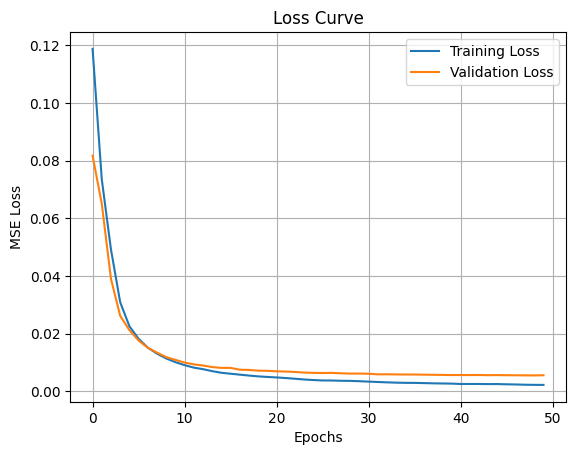

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = autoencoder.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=62,
    validation_data=(x_test, x_test)
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


#Evaluate the Model

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0054
Test MSE Loss: 0.0055
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Average MSE on the test set: 0.0055


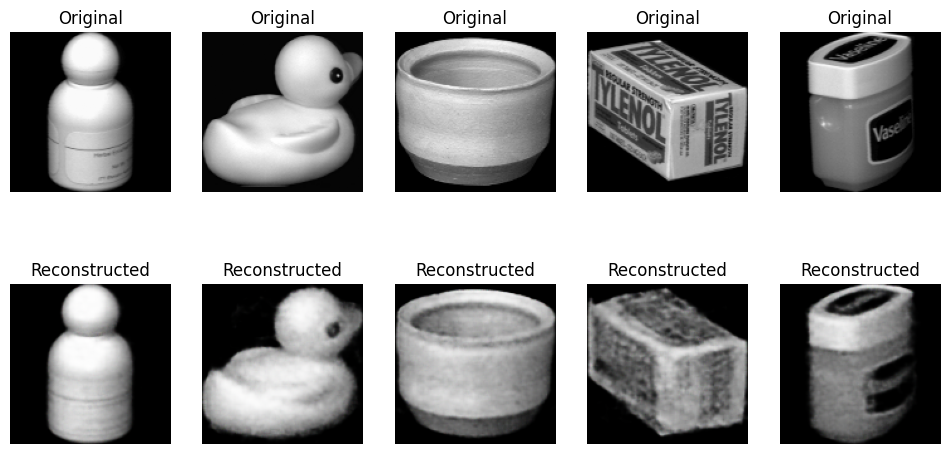

In [32]:
from sklearn.metrics import mean_squared_error

test_loss = autoencoder.evaluate(x_test, x_test)
print(f"Test MSE Loss: {test_loss:.4f}")

reconstructed_images = autoencoder.predict(x_test)

mse_values = [mean_squared_error(x_test[i].flatten(), reconstructed_images[i].flatten()) for i in range(len(x_test))]
average_mse = np.mean(mse_values)
print(f"Average MSE on the test set: {average_mse:.4f}")

n = 5
plt.figure(figsize=(12, 6))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, n, i + n + 1)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()


#Inference

Test MSE Loss:
The model's Mean Squared Error (MSE) on the test set is 0.0055, indicating a very low reconstruction error. This suggests that the autoencoder has learned to reconstruct the images with high accuracy.

Average MSE on the Test Set:
The average MSE value on the test set is 0.0055, which reinforces that the overall reconstruction quality is excellent.